In [387]:
import gpxpy
import gpxpy.gpx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import timedelta
from xml.dom import minidom
from gpxpy import geo
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
from bokeh.models import ColumnDataSource, GMapOptions,HoverTool

%matplotlib inline

In [288]:
gpx_file = open('Evening_Activity.gpx', 'r')

gpx = gpxpy.parse(gpx_file)
df = pd.DataFrame(columns=['lon', 'lat', 'alt', 'time'])
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            df = df.append({'lon': point.longitude, 'lat' : point.latitude, 'alt' : point.elevation, 'time' : point.time}, ignore_index=True)

In [289]:
df.head()

,lon,lat,alt,time
0,-6.319618,53.346205,7.8,2020-03-19 18:35:46+00:00
1,-6.319618,53.346205,7.8,2020-03-19 18:35:47+00:00
2,-6.319618,53.346205,7.8,2020-03-19 18:35:48+00:00
3,-6.319603,53.346211,7.8,2020-03-19 18:35:49+00:00
4,-6.319607,53.346187,7.8,2020-03-19 18:35:53+00:00


In [37]:
df['delta'] = df['time'] - df['time'].shift(1)
df['delta'].describe()

count                       450
mean     0 days 00:00:07.946666
std      0 days 00:00:06.301044
min             0 days 00:00:01
25%             0 days 00:00:01
50%             0 days 00:00:06
75%             0 days 00:00:14
max             0 days 00:00:27
Name: delta, dtype: object

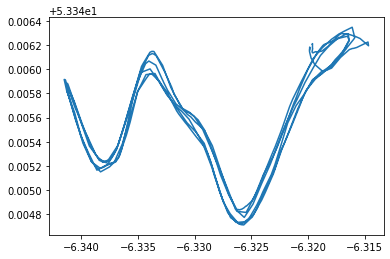

In [40]:
plt.plot(df['lon'], df['lat'])

In [41]:
df[['lon','lat']]

,lon,lat
0,-6.319618,53.346205
1,-6.319618,53.346205
2,-6.319618,53.346205
3,-6.319603,53.346211
4,-6.319607,53.346187
...,...,...
446,-6.319862,53.346144
447,-6.319865,53.346152
448,-6.319827,53.346180
449,-6.319851,53.346182


In [117]:
# GOOGLE_MAPS_API_KEY = 'FILL THIS IN'
output_file("gmap.html")

source = ColumnDataSource(
    data=dict(lat= mistakes['lat'],
              lon= mistakes['lon'],
             upstream=mistakes['upstream'],
             time_on_incorrect_side=mistakes['time_on_incorrect_side'])
)

map_options = GMapOptions(lat=53.346205, lng=-6.319618, map_type="roadmap", zoom=11)

TOOLTIPS = [
    ("Upstream", "@upstream"),
    ("Duration of infringment", "@time_on_incorrect_side")
]



p = gmap(GOOGLE_MAPS_API_KEY, map_options, title=f"You spent {total_wrong_side_time} seconds on the wrong side of the river!")
p.add_tools(HoverTool(tooltips=TOOLTIPS))

p.circle(x="lon", y="lat", size=15, fill_color="blue", fill_alpha=0.8, source=source)

show(p)

# Defining the banks

In [ ]:
from xml.dom import minidom

# parse an xml file by name
mydoc = minidom.parse("south_bank.gpx")

items = mydoc.getElementsByTagName('rtept')
    
south_bank['lon'] = [float(elem.attributes['lon'].value) for elem in items]
south_bank['lat'] = [float(elem.attributes['lat'].value) for elem in items]

In [148]:
mydoc = minidom.parse("north_bank.gpx")

items = mydoc.getElementsByTagName('rtept')
north_bank=pd.DataFrame()
    
north_bank['lon'] = [float(elem.attributes['lon'].value) for elem in items]
north_bank['lat'] = [float(elem.attributes['lat'].value) for elem in items]

In [149]:
north_bank.head(3)

,lon,lat
0,-6.31503,53.34639
1,-6.31545,53.34636
2,-6.31592,53.34637


In [150]:
south_bank.head(3)

,lon,lat
0,-6.31413,53.34628
1,-6.31483,53.34617
2,-6.31525,53.34615


## Adding more datapoints

In [92]:
def get_geo_translation(x1,y1,x2,y2):
    return (x2-x1),(y2-y1)

In [152]:
def smooth_geo_path_points(x1,y1,x2,y2,smooth_factor=0.1):
    """Return more points between two points. This smooths out the path. The lower the smooth factor
    the more intermediate points that there will be."""
    
    x_trans,y_trans = get_geo_translation(x1,y1,x2,y2)
    
    smooth_x = [x1]
    smooth_y = [y1]
   
    for factor in np.arange(smooth_factor,1,smooth_factor):
        smooth_x.append(x1+(factor*x_trans))
        smooth_y.append(y1+(factor*y_trans))
    
    smooth_x.append(x2)
    smooth_y.append(y2)
    
    return smooth_x, smooth_y

In [153]:
def smooth_geo_path(path,smooth_factor=0.1):
    """Generates a new smoothed path based on the old path."""
    interpolated_x = []
    interpolated_y = []

    for index, rows in path.iterrows():
        if index == 0:
            pass
        else:
            smooth_x, smooth_y = smooth_geo_path_points(path.iloc[index-1]['lon'],path.iloc[index-1]['lat'],path.iloc[index]['lon'],path.iloc[index]['lat'],smooth_factor)
            interpolated_x.append(smooth_x)
            interpolated_y.append(smooth_y)
    
    return interpolated_x,interpolated_y

In [154]:
interpolated_south_bank_x = [item for sublist in smooth_geo_path(south_bank)[0] for item in sublist]
interpolated_south_bank_y = [item for sublist in smooth_geo_path(south_bank)[1] for item in sublist]

In [155]:
interpolated_north_bank_x = [item for sublist in smooth_geo_path(north_bank)[0] for item in sublist]
interpolated_north_bank_y = [item for sublist in smooth_geo_path(north_bank)[1] for item in sublist]

### Interpolated datasets

In [174]:
interpolated_south_bank=pd.DataFrame()
interpolated_south_bank['lat'] = interpolated_south_bank_y
interpolated_south_bank['lon'] = interpolated_south_bank_x

interpolated_north_bank=pd.DataFrame()
interpolated_north_bank['lat'] = interpolated_north_bank_y
interpolated_north_bank['lon'] = interpolated_north_bank_x

## Finding river midpoint

In [210]:
def closest_point(point,other_bank):
    
    for index,row in other_bank.iterrows():
        distance = geo.haversine_distance(point[0],point[1],row['lat'],row['lon'])
        try:
            if distance < shortest_distance:
                shortest_distance = distance
                shortest_distance_coordinates = row['lat'],row['lon']
        except:
            shortest_distance = distance
            shortest_distance_coordinates = row['lat'],row['lon']
    
    return shortest_distance_coordinates
    

In [211]:
def find_river_midpoint(bank1,bank2):
    midpoints_lat = []
    midpoints_lon = []
    for index,row in bank1.iterrows():
        closest_point = closest_point((row['lat'],row['lon']),bank2)
        midpoints_lat.append((row['lat']+closest_point[0])/2)
        midpoints_lon.append((row['lon']+closest_point[1])/2)
    return midpoints_lat, midpoints_lon

In [204]:
midpoint = find_river_midpoint(interpolated_south_bank,interpolated_north_bank)

In [207]:
midpoint_df = pd.DataFrame()
midpoint_df['lat'] = midpoint[0]
midpoint_df['lon'] = midpoint[1]

In [208]:
midpoint_df.head(3)

,lat,lon
0,53.346335,-6.314580
1,53.346329,-6.314615
2,53.346324,-6.314650


## Visualise in Google Maps

In [344]:
# GOOGLE_MAPS_API_KEY = 'FILL THIS IN'
output_file("gmap.html")

source = ColumnDataSource(
    data=dict(lat= mistakes['lat'],
              lon= mistakes['lon'],
             upstream=mistakes['upstream'],
             time_on_incorrect_side=mistakes['time_on_incorrect_side'])
)

map_options = GMapOptions(lat=53.346205, lng=-6.319618, map_type="roadmap", zoom=11)

TOOLTIPS = [
    ("Upstream", "@upstream"),
    ("Duration of infringment", "@time_on_incorrect_side")
]



p = gmap(GOOGLE_MAPS_API_KEY, map_options, title=f"You spent {total_wrong_side_time} seconds on the wrong side of the river!")
p.add_tools(HoverTool(tooltips=TOOLTIPS))

p.circle(x="lon", y="lat", size=15, fill_color="blue", fill_alpha=0.8, source=source)

show(p)

## Across the line or Not Across the line?

In [217]:
df.head(4)

,lon,lat,alt,time,delta
0,-6.319618,53.346205,7.8,2020-03-19 18:35:46+00:00,NaT
1,-6.319618,53.346205,7.8,2020-03-19 18:35:47+00:00,00:00:01
2,-6.319618,53.346205,7.8,2020-03-19 18:35:48+00:00,00:00:01
3,-6.319603,53.346211,7.8,2020-03-19 18:35:49+00:00,00:00:01


In [359]:
def is_correct_side(point, midpoint_df, upstream_direction):
    closest_midpoint = closest_point(point,midpoint_df)
    
    if upstream_direction == True:
        if point[0] < closest_midpoint[0]: # lat should be lower than the mid of river on the way up
            return True
        else:
            return False
    
    if upstream_direction == False:
        if point[0] > closest_midpoint[0]: # lat should be higher than the mid of river on the way down
            return True
        else:
            return False


In [360]:
def assign_side_var(rower_data,midpoint_df):
    upstream = [None] # first time point
    correct_side = [True] # start on correct side
    
    for index,row in rower_data.iterrows():
        if index == 0:
            pass
        else:
            if rower_data.iloc[index]['lon'] <= rower_data.iloc[index-1]['lon']: # if you're going upstream, longitude gets lower
                upstream.append(True)
                point = row['lat'], row['lon']
                correct_side.append(is_correct_side(point, midpoint_df, upstream_direction=True))
            else:
                upstream.append(False)
                point = row['lat'], row['lon']
                correct_side.append(is_correct_side(point, midpoint_df, upstream_direction=False))
                
    rower_data['upstream'] = upstream
    rower_data['correct_side'] = correct_side
    
    return rower_data

In [361]:
rower_data = assign_side_var(df,midpoint_df)

In [362]:
def calculate_time_on_incorrect_side(rower_data):
    time_on_incorrect_side = [0]
    for index,row in rower_data.iterrows():
        if index == 0:
            pass
        else:
            if rower_data.iloc[index]['correct_side'] == False and rower_data.iloc[index-1]['correct_side'] == False:
                time_on_incorrect_side.append(pd.Timedelta(rower_data.iloc[index]['time'] - rower_data.iloc[index-1]['time']).seconds)
            else:
                time_on_incorrect_side.append(0)
    rower_data['time_on_incorrect_side'] = time_on_incorrect_side
    return rower_data

In [363]:
rower_data

,lon,lat,alt,time,upstream,correct_side,time_on_incorrect_side
0,-6.319618,53.346205,7.8,2020-03-19 18:35:46+00:00,None,True,0
1,-6.319618,53.346205,7.8,2020-03-19 18:35:47+00:00,True,False,0
2,-6.319618,53.346205,7.8,2020-03-19 18:35:48+00:00,True,False,1
3,-6.319603,53.346211,7.8,2020-03-19 18:35:49+00:00,False,True,0
4,-6.319607,53.346187,7.8,2020-03-19 18:35:53+00:00,True,False,0
...,...,...,...,...,...,...,...
446,-6.319862,53.346144,7.7,2020-03-19 19:34:22+00:00,True,False,15
447,-6.319865,53.346152,7.7,2020-03-19 19:34:32+00:00,True,False,10
448,-6.319827,53.346180,7.7,2020-03-19 19:34:59+00:00,False,True,0
449,-6.319851,53.346182,7.6,2020-03-19 19:35:13+00:00,True,False,0


In [372]:
df = assign_side_var(df,midpoint_df)
df = calculate_time_on_incorrect_side(df)
mistakes = df[df['time_on_incorrect_side'] != 0]
mistakes
total_wrong_side_time = sum(df['time_on_incorrect_side'])

In [375]:
# GOOGLE_MAPS_API_KEY = 'FILL THIS IN'
output_file("gmap.html")

source = ColumnDataSource(
    data=dict(lat= mistakes['lat'],
              lon= mistakes['lon'],
             upstream=mistakes['upstream'],
             time_on_incorrect_side=mistakes['time_on_incorrect_side'])
)

map_options = GMapOptions(lat=53.346205, lng=-6.319618, map_type="roadmap", zoom=11)

TOOLTIPS = [
    ("Upstream", "@upstream"),
    ("Duration of infringment", "@time_on_incorrect_side")
]



p = gmap(GOOGLE_MAPS_API_KEY, map_options, title=f"You spent {total_wrong_side_time} seconds on the wrong side of the river!")
p.add_tools(HoverTool(tooltips=TOOLTIPS))

p.circle(x="lon", y="lat", size=15, fill_color="blue", fill_alpha=0.8, source=source)

show(p)

# Beggy Data

In [376]:
gpx_file = open('1x_Lovely_conditons_Hunting_treasure_.gpx', 'r')

gpx = gpxpy.parse(gpx_file)
df = pd.DataFrame(columns=['lon', 'lat', 'alt', 'time'])
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            df = df.append({'lon': point.longitude, 'lat' : point.latitude, 'alt' : point.elevation, 'time' : point.time}, ignore_index=True)

In [377]:
df = assign_side_var(df,midpoint_df)
df = calculate_time_on_incorrect_side(df)
mistakes = df[df['time_on_incorrect_side'] != 0]
mistakes
total_wrong_side_time = sum(df['time_on_incorrect_side'])

In [379]:
# GOOGLE_MAPS_API_KEY = 'FILL THIS IN'
output_file("gmap.html")

source = ColumnDataSource(
    data=dict(lat= mistakes['lat'],
              lon= mistakes['lon'],
             upstream=mistakes['upstream'],
             time_on_incorrect_side=mistakes['time_on_incorrect_side'])
)

map_options = GMapOptions(lat=53.346205, lng=-6.319618, map_type="roadmap", zoom=11)

TOOLTIPS = [
    ("Upstream", "@upstream"),
    ("Duration of infringment", "@time_on_incorrect_side")
]



p = gmap(GOOGLE_MAPS_API_KEY, map_options, title=f"You spent {total_wrong_side_time} seconds on the wrong side of the river!")
p.add_tools(HoverTool(tooltips=TOOLTIPS))

p.circle(x="lon", y="lat", size=15, fill_color="blue", fill_alpha=0.8, source=source)

show(p)

# Scooter Data

In [383]:
gpx_file = open('scott scull.gpx', 'r')

gpx = gpxpy.parse(gpx_file)
df = pd.DataFrame(columns=['lon', 'lat', 'alt', 'time'])
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            df = df.append({'lon': point.longitude, 'lat' : point.latitude, 'alt' : point.elevation, 'time' : point.time}, ignore_index=True)

In [384]:
df = assign_side_var(df,midpoint_df)
df = calculate_time_on_incorrect_side(df)
mistakes = df[df['time_on_incorrect_side'] != 0]
mistakes
total_wrong_side_time = sum(df['time_on_incorrect_side'])

In [386]:
# GOOGLE_MAPS_API_KEY = 'FILL THIS IN'
output_file("gmap.html")

source = ColumnDataSource(
    data=dict(lat= mistakes['lat'],
              lon= mistakes['lon'],
             upstream=mistakes['upstream'],
             time_on_incorrect_side=mistakes['time_on_incorrect_side'])
)

map_options = GMapOptions(lat=53.346205, lng=-6.319618, map_type="roadmap", zoom=11)

TOOLTIPS = [
    ("Upstream", "@upstream"),
    ("Duration of infringment", "@time_on_incorrect_side")
]



p = gmap(GOOGLE_MAPS_API_KEY, map_options, title=f"You spent {total_wrong_side_time} seconds on the wrong side of the river!")
p.add_tools(HoverTool(tooltips=TOOLTIPS))

p.circle(x="lon", y="lat", size=15, fill_color="blue", fill_alpha=0.8, source=source)

show(p)